In [3]:
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm

import gensim
from gensim.utils import simple_preprocess

# sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\atama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Код шукає перший доступний CSV-файл із двох можливих назв, завантажує його в DataFrame, а якщо жоден не знайдено — виводить помилку.

In [4]:
paths = [
    "Corona_NLP_train.csv", "Corona_NLP_test.csv"
]
for p in paths:
    if os.path.exists(p):
        df = pd.read_csv(p, encoding='latin1')
        print("Loaded", p)
        break
else:
    raise FileNotFoundError("Не знайдено файл датасету. Завантаж файл з Kaggle і помістіть у робочу директорію.")

df.head()

Loaded Corona_NLP_train.csv


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Код шукає правильні назви колонок з текстом і sentiment у датасеті, обирає перші знайдені варіанти з можливих назв і привласнює їх у змінні text_col та label_col.

In [5]:
print(df.columns)
for candidate in ['Original Tweet', 'OriginalTweet', 'tweet', 'text', 'Tweet', 'Tweet At', 'Original_Tweet', 'OriginalTweet']:
    if candidate in df.columns:
        text_col = candidate
        break
else:
    raise ValueError("Не знайдено колонки з текстом. Перевір назви колонок: ", df.columns)

for candidate in ['Sentiment', 'SentimentText', 'Label', 'label', 'Sentiment ']:
    if candidate in df.columns:
        label_col = candidate
        break
else:
    label_col = 'Sentiment'

print("text_col:", text_col, "label_col:", label_col)

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')
text_col: OriginalTweet label_col: Sentiment


In [6]:
stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text):
    if pd.isna(text):
        return []
    text = str(text).lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'rt\b', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = simple_preprocess(text, deacc=True, min_len=2)
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

print(clean_and_tokenize("RT @user: COVID-19 is terrible!"))

['covid', 'terrible']


In [7]:
# Tokenize and split
df['tokens'] = df[text_col].progress_apply(clean_and_tokenize)
df = df[df['tokens'].map(len) > 0].reset_index(drop=True)

le = LabelEncoder()
df['y'] = le.fit_transform(df[label_col].astype(str))
print("Classes:", list(le.classes_))

X = df[text_col].values
y = df['y'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=RANDOM_STATE)
print("Train:", len(X_train), "Test:", len(X_test))

100%|██████████| 41157/41157 [00:04<00:00, 10090.21it/s]

Classes: ['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive']
Train: 32897 Test: 8225


In [8]:
#  Word2Vec transformer for Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=300, window=5, min_count=2, workers=4, epochs=10, sg=0):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.epochs = epochs
        self.sg = sg
        self.w2v_model_ = None

    def fit(self, X, y=None):
        sentences = [clean_and_tokenize(doc) for doc in X]
        sentences = [s for s in sentences if len(s) > 0]
        self.w2v_model_ = gensim.models.Word2Vec(
            sentences=sentences,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            workers=self.workers,
            sg=self.sg,
            epochs=self.epochs
        )
        self.kv_ = self.w2v_model_.wv
        return self

    def transform(self, X):
        vectors = np.zeros((len(X), self.vector_size), dtype=float)
        for i, doc in enumerate(X):
            tokens = clean_and_tokenize(doc)
            vecs = [self.kv_[w] for w in tokens if w in self.kv_]
            if len(vecs) > 0:
                vectors[i, :] = np.mean(vecs, axis=0)
            else:
                vectors[i, :] = np.zeros(self.vector_size)
        return vectors

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y)
        return self.transform(X)

In [9]:
# Classifiers and PCA settings
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "SVM": SVC(kernel='linear', probability=False, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    "GaussianNB": GaussianNB()
}

pca_variants = [None, 50, 100, 200]
EMBED_SIZE = 300

In [10]:
# Train & evaluate
from sklearn.metrics import precision_recall_fscore_support

results = []

for pca_n in pca_variants:
    for clf_name, clf in classifiers.items():
        print(f"Training {clf_name} | PCA={pca_n}")
        steps = []
        steps.append(('w2v', Word2VecVectorizer(vector_size=EMBED_SIZE, epochs=10, workers=4)))
        if pca_n is not None:
            steps.append(('pca', PCA(n_components=pca_n, random_state=RANDOM_STATE)))
        steps.append(('clf', clf))
        pipe = Pipeline(steps)

        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True, zero_division=0)
        cm = confusion_matrix(y_test, y_pred)

        res = {
            'model': clf_name,
            'pca_n': 'None' if pca_n is None else pca_n,
            'accuracy': acc,
            'report': report,
            'confusion_matrix': cm
        }
        results.append(res)

        model_fname = f"pipeline_{clf_name}_pca_{'None' if pca_n is None else pca_n}.joblib"
        joblib.dump(pipe, model_fname)
        print(f"Saved pipeline to {model_fname}. Accuracy: {acc:.4f}")

Training LogisticRegression | PCA=None
Saved pipeline to pipeline_LogisticRegression_pca_None.joblib. Accuracy: 0.4209
Training SVM | PCA=None
Saved pipeline to pipeline_SVM_pca_None.joblib. Accuracy: 0.4139
Training RandomForest | PCA=None
Saved pipeline to pipeline_RandomForest_pca_None.joblib. Accuracy: 0.4243
Training GaussianNB | PCA=None
Saved pipeline to pipeline_GaussianNB_pca_None.joblib. Accuracy: 0.3065
Training LogisticRegression | PCA=50
Saved pipeline to pipeline_LogisticRegression_pca_50.joblib. Accuracy: 0.3926
Training SVM | PCA=50
Saved pipeline to pipeline_SVM_pca_50.joblib. Accuracy: 0.3792
Training RandomForest | PCA=50
Saved pipeline to pipeline_RandomForest_pca_50.joblib. Accuracy: 0.4214
Training GaussianNB | PCA=50
Saved pipeline to pipeline_GaussianNB_pca_50.joblib. Accuracy: 0.3382
Training LogisticRegression | PCA=100
Saved pipeline to pipeline_LogisticRegression_pca_100.joblib. Accuracy: 0.4170
Training SVM | PCA=100
Saved pipeline to pipeline_SVM_pca_100.j

In [11]:
# Collect metrics into DataFrame
rows = []
for r in results:
    acc = r['accuracy']
    rep = r['report']
    macro_f1 = rep.get('macro avg', {}).get('f1-score', None)
    for cls in le.classes_:
        cls_prec = rep.get(cls, {}).get('precision', None)
        cls_rec = rep.get(cls, {}).get('recall', None)
        cls_f1 = rep.get(cls, {}).get('f1-score', None)
        rows.append({
            'model': r['model'],
            'pca_n': r['pca_n'],
            'accuracy': acc,
            'macro_f1': macro_f1,
            'class': cls,
            'precision': cls_prec,
            'recall': cls_rec,
            'f1': cls_f1
        })

metrics_df = pd.DataFrame(rows)
metrics_df_pivot = metrics_df.pivot_table(index=['model','pca_n'], columns='class', values=['precision','recall','f1'])
metrics_df_pivot

f1                               \
class                    Extremely Negative Extremely Positive  Negative   
model              pca_n                                                   
GaussianNB         50              0.359788           0.403289  0.269463   
                   100             0.335138           0.423423  0.225352   
                   200             0.320596           0.393059  0.200214   
                   None            0.344334           0.387902  0.217361   
LogisticRegression 50              0.320442           0.376959  0.355642   
                   100             0.360403           0.409153  0.381115   
                   200             0.359066           0.413857  0.387254   
                   None            0.366567           0.411656  0.385142   
RandomForest       50              0.326885           0.381764  0.394061   
                   100             0.345343           0.382323  0.394712   
                   200             0.307801           0.348634  0.394938   
                   None            0.341935           0.422847  0.387902   
SVM                50              0.017794           0.337090  0.374805   
                   100             0.206373           0.368367  0.389066   
                   200             0.211568           0.372285  0.401886   
                   None            0.209811           0.369948  0.401713   

                                                      precision  \
class                      Neutral  Positive Extremely Negative   
model              pca_n                                          
GaussianNB         50     0.396974  0.272897           0.273028   
                   100    0.375326  0.245392           0.233561   
                   200    0.354487  0.219660           0.215269   
                   None   0.412990  0.118169           0.261342   
LogisticRegression 50     0.455074  0.412594           0.489681   
                   100    0.492413  0.420072           0.514382   
                   200    0.502317  0.428029           0.521739   
                   None   0.486316  0.430176           0.530225   
RandomForest       50     0.495258  0.442967           0.607940   
                   100    0.481230  0.453917           0.677333   
                   200    0.492093  0.460733           0.691083   
                   None   0.493489  0.438618           0.583700   
SVM                50     0.452664  0.428379           0.357143   
                   100    0.479328  0.435807           0.612613   
                   200    0.486557  0.444798           0.637615   
                   None   0.490434  0.443891           0.606987   

                                                                           \
class                    Extremely Positive  Negative   Neutral  Positive   
model              pca_n                                                    
GaussianNB         50              0.357434  0.364574  0.370831  0.349760   
                   100             0.421210  0.336673  0.338028  0.358586   
                   200             0.422376  0.341434  0.310632  0.357708   
                   None            0.284407  0.349330  0.390046  0.268634   
LogisticRegression 50              0.484024  0.345024  0.451861  0.354514   
                   100             0.519767  0.370247  0.469581  0.371179   
                   200             0.533333  0.374236  0.477954  0.377934   
                   None            0.531661  0.373814  0.470481  0.375736   
RandomForest       50              0.567809  0.370075  0.537757  0.362748   
                   100             0.599034  0.377298  0.533703  0.363660   
                   200             0.631683  0.375227  0.565511  0.361284   
                   None            0.542553  0.370302  0.520984  0.368343   
SVM                50              0.524721  0.335592  0.472714  0.348219   
                   100             0.568504  0.354946  0.475641  0.364198   
             

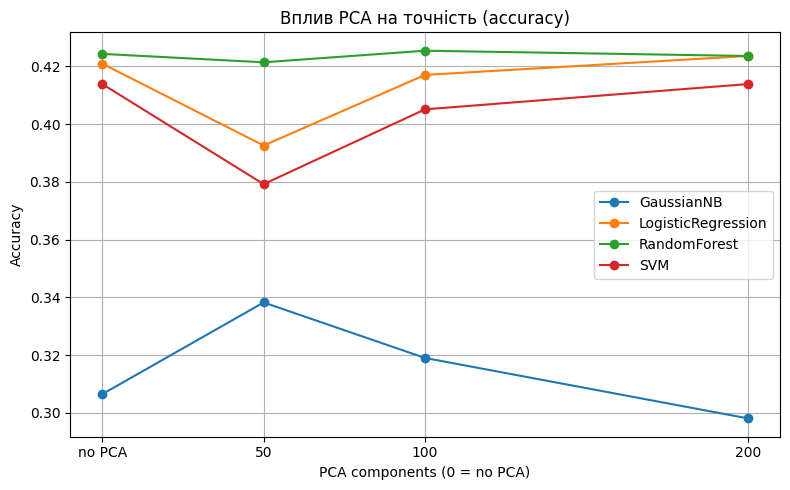

In [12]:
# Plot accuracy vs PCA components for each model
acc_df = metrics_df.groupby(['model','pca_n'])['accuracy'].first().reset_index()

plt.figure(figsize=(8,5))
for model in acc_df['model'].unique():
    dfm = acc_df[acc_df['model']==model].copy()
    dfm['pca_plot'] = dfm['pca_n'].apply(lambda x: 0 if x=='None' else int(x))
    dfm = dfm.sort_values('pca_plot')
    plt.plot(dfm['pca_plot'], dfm['accuracy'], marker='o', label=model)

plt.xticks([0,50,100,200], labels=['no PCA','50','100','200'])
plt.xlabel("PCA components (0 = no PCA)")
plt.ylabel("Accuracy")
plt.title("Вплив PCA на точність (accuracy)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Best: {'model': 'RandomForest', 'pca_n': 100, 'accuracy': 0.42541033434650455}


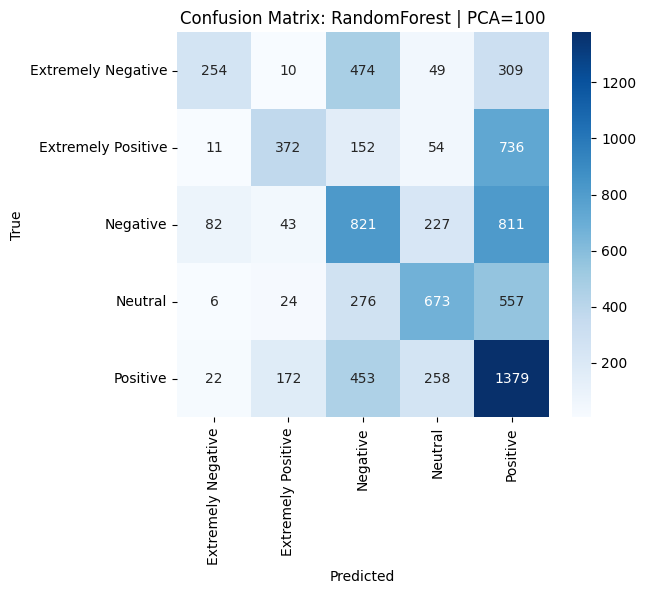

                    precision    recall  f1-score   support

Extremely Negative       0.68      0.23      0.35      1096
Extremely Positive       0.60      0.28      0.38      1325
          Negative       0.38      0.41      0.39      1984
           Neutral       0.53      0.44      0.48      1536
          Positive       0.36      0.60      0.45      2284

          accuracy                           0.43      8225
         macro avg       0.51      0.39      0.41      8225
      weighted avg       0.48      0.43      0.42      8225



In [13]:
# Confusion Matrix for the best model
acc_df = metrics_df.groupby(['model','pca_n'])['accuracy'].first().reset_index()
best = acc_df.sort_values('accuracy', ascending=False).iloc[0]
print("Best:", best.to_dict())

best_model_name = best['model']
best_pca = best['pca_n']
best_fname = f"pipeline_{best_model_name}_pca_{'None' if best_pca=='None' else best_pca}.joblib"
pipe_best = joblib.load(best_fname)

y_pred_best = pipe_best.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix: {best_model_name} | PCA={best_pca}")
plt.show()

print(classification_report(y_test, y_pred_best, target_names=le.classes_, zero_division=0))

In [14]:
# Predict new tweet example
def predict_tweet(text, pipeline):
    pred_idx = pipeline.predict([text])[0]
    return le.inverse_transform([pred_idx])[0]

example = "I got vaccinated today! Feeling hopeful."
print("Prediction:", predict_tweet(example, pipe_best))

Prediction: Positive
